# Fit the final model and make predictions

In [1]:
library(magrittr)
library(boot)

## Prepare datasets

## Take all features which aren't part of an arbitrary blacklist?

In [2]:
blacklist = readr::read_tsv('features/blacklist.tsv')$feature

feature_df = readr::read_tsv('features/transformed-features.tsv.bz2') %>%
  dplyr::select(-dplyr::one_of(blacklist))

Parsed with column specification:
cols(
  feature = col_character()
)
Parsed with column specification:
cols(
  compound_id = col_character(),
  compound_name = col_character(),
  disease_id = col_character(),
  disease_name = col_character(),
  category = col_character(),
  origin = col_character(),
  status = col_integer(),
  prior_logit = col_double(),
  prior_prob = col_double(),
  degree_CbG = col_double(),
  degree_CtD = col_double(),
  degree_DaG = col_double(),
  degree_DtC = col_double(),
  dwpc_CbGaD = col_double(),
  dwpc_CbGaDaGaD = col_double(),
  dwpc_CbGaDtCtD = col_double(),
  dwpc_CbGbCbGaD = col_double(),
  dwpc_CbGbCtD = col_double(),
  dwpc_CtDtCtD = col_double()
)
Warning message in dplyr::one_of(blacklist):
“Unknown variables: `dwpc_CtDtCrCtD`, `dwpc_CtDrDtCtD`, `dwpc_CcSEcCrCtD`, `dwpc_CrCtDlAlD`, `dwpc_CrCtDaGaD`, `dwpc_CrCdGdCtD`, `dwpc_CrCtDpSpD`, `dwpc_CrCuGuCtD`, `dwpc_CrCtDuGaD`, `dwpc_CrCtDdGaD`, `dwpc_CrCcSEcCtD`, `dwpc_CrCrCtDrD`, `dwpc_CdGdCrCtD`, `dwpc

In [3]:
dim(feature_df)

[1] 55598    16

In [4]:
head(feature_df, 2)

compound_id,compound_name,disease_id,disease_name,category,origin,status,prior_logit,prior_prob,degree_CbG,degree_DaG,dwpc_CbGaD,dwpc_CbGaDaGaD,dwpc_CbGbCbGaD,dwpc_CbGbCtD,dwpc_CtDtCtD
DB00014,NA,DOID:0050742,NA,NA,train,0,-6.489,0.001517,-1.420,-1.357,-0.5141,-1.3330,-1.0140,-0.7021,-0.2954
DB00091,NA,DOID:0050742,NA,NA,train,0,-5.315,0.004893,1.528,-1.357,-0.5141,-0.6278,0.4744,-0.7021,-0.2954


## Split training and holdout sets

In [5]:
train_df = subset(feature_df, origin == 'train')

In [6]:
dim(train_df)

[1] 38889    16

In [7]:
head(train_df)

compound_id,compound_name,disease_id,disease_name,category,origin,status,prior_logit,prior_prob,degree_CbG,degree_DaG,dwpc_CbGaD,dwpc_CbGaDaGaD,dwpc_CbGbCbGaD,dwpc_CbGbCtD,dwpc_CtDtCtD
DB00014,NA,DOID:0050742,NA,NA,train,0,-6.489,0.001517,-1.4200,-1.357,-0.5141,-1.3330,-1.0140,-0.7021,-0.2954
DB00091,NA,DOID:0050742,NA,NA,train,0,-5.315,0.004893,1.5280,-1.357,-0.5141,-0.6278,0.4744,-0.7021,-0.2954
DB00104,NA,DOID:0050742,NA,NA,train,0,-6.489,0.001517,-0.2547,-1.357,-0.5141,-0.3303,-1.0140,-0.7021,-0.2954
DB00122,NA,DOID:0050742,NA,NA,train,0,-Inf,0.000000,1.5640,-1.357,-0.5141,-0.7777,1.5050,-0.7021,-0.2954
DB00126,NA,DOID:0050742,NA,NA,train,0,-6.489,0.001517,1.2320,-1.357,-0.5141,-1.2460,-0.9812,-0.7021,-0.2954
DB00136,NA,DOID:0050742,NA,NA,train,0,-5.758,0.003148,-0.6963,-1.357,-0.5141,-0.7934,-0.5424,-0.7021,-0.2954


In [8]:
test_rels = subset(feature_df, origin == 'holdout')

In [9]:
dim(test_rels)

[1] 16709    16

In [10]:
head(test_rels)

compound_id,compound_name,disease_id,disease_name,category,origin,status,prior_logit,prior_prob,degree_CbG,degree_DaG,dwpc_CbGaD,dwpc_CbGaDaGaD,dwpc_CbGbCbGaD,dwpc_CbGbCtD,dwpc_CtDtCtD
DB00014,NA,DOID:10283,NA,NA,holdout,0,-3.666,0.02494,-1.4200,1.91,-0.5141,0.5407,-0.7589,-0.7021,-0.2954
DB00091,NA,DOID:10283,NA,NA,holdout,0,-2.491,0.07648,1.5280,1.91,2.2390,1.5820,2.5810,2.5800,0.9558
DB00136,NA,DOID:10283,NA,NA,holdout,0,-2.934,0.05051,-0.6963,1.91,1.7040,1.1920,0.8969,0.3356,3.7720
DB00158,NA,DOID:10283,NA,NA,holdout,0,-Inf,0.00000,0.5103,1.91,1.1520,1.3610,1.6470,0.5575,-0.2954
DB00177,NA,DOID:10283,NA,NA,holdout,0,-2.934,0.05051,-0.4542,1.91,-0.5141,1.1140,1.1050,1.4500,-0.2954
DB00184,NA,DOID:10283,NA,NA,holdout,0,-Inf,0.00000,1.5990,1.91,2.2620,2.2190,2.5600,1.5570,-0.2954


## Train regression model

In [11]:
train_df = train_df %>%
    dplyr::filter(prior_prob > 0)

In [12]:
dim(train_df)

[1] 18403    16

In [13]:
X_train = train_df %>%
  dplyr::select(prior_logit, dplyr::starts_with('degree_'), dplyr::starts_with('dwpc_')) %>%
  as.matrix()

y_train = train_df$status

In [14]:
dim(X_train)

[1] 18403     8

In [15]:
sum(train_df$status)

[1] 592

In [16]:
head(X_train)

prior_logit,degree_CbG,degree_DaG,dwpc_CbGaD,dwpc_CbGaDaGaD,dwpc_CbGbCbGaD,dwpc_CbGbCtD,dwpc_CtDtCtD
-6.489,-1.42000,-1.357,-0.5141,-1.3330,-1.0140,-0.7021,-0.2954
-5.315,1.52800,-1.357,-0.5141,-0.6278,0.4744,-0.7021,-0.2954
-6.489,-0.25470,-1.357,-0.5141,-0.3303,-1.0140,-0.7021,-0.2954
-6.489,1.23200,-1.357,-0.5141,-1.2460,-0.9812,-0.7021,-0.2954
-5.758,-0.69630,-1.357,-0.5141,-0.7934,-0.5424,-0.7021,-0.2954
-5.758,-0.08534,-1.357,-0.5141,-1.1820,-0.6349,-0.7021,-0.2954


---

## Fit Model

In [17]:
lambda = 'lambda.1se'
penalty = ifelse(colnames(X_train) == 'prior_logit', 0, 1)

In [18]:
fit = hetior::glmnet_train(X = X_train, y = y_train, alpha = 0.2, s = lambda, cores = 10, seed = 0,
  penalty.factor=penalty, lambda.min.ratio=1e-8, nlambda=150, standardize=TRUE)

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-5



---

[1] 0.01143126

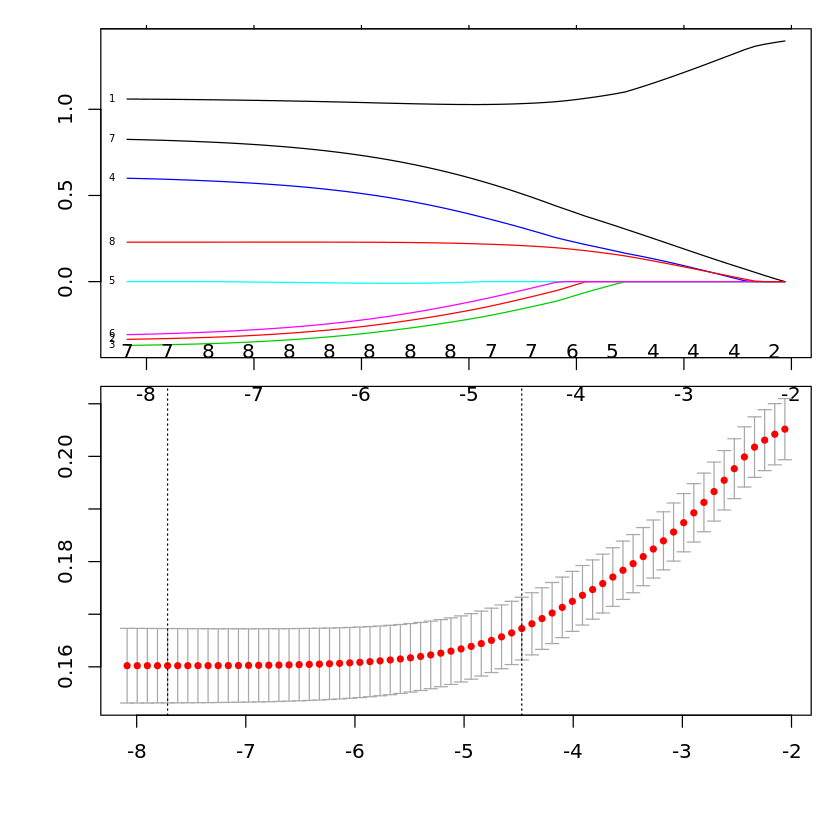

In [19]:
par(mfrow = c(2,1), oma = c(5,4,0,0) + 0.1, mar = c(0,0,1,1) + 0.1)
plot(fit$cv_model$glmnet.fit, xvar = "lambda", label = TRUE)
plot(fit$cv_model)
fit$cv_model[[lambda]]

In [20]:
# The coefficient for prior_logit should be around 1 for our approach to work well
dplyr::filter(fit$coef_df, feature == 'prior_logit')$coef

[1] 1.033723

In [21]:
# Number of negative and positive coefficients
fit$coef_df %>%
  dplyr::filter(feature != 'intercept', zcoef != 0) %>%
  .[['zcoef']] %>% sign %>% table

.
-1  1 
 3  4 

In [22]:
# Sum of prior (should sum to the number of treatments)
sum(feature_df$prior_prob)

# Prevalence of positives as percent
scales::percent(mean(feature_df$status))

[1] 636.2386

[1] "1.06%"

Prior has a larger sum than the number of positive examples we fed into the model. Wonder if this difference is significant.

## Make predictions

In [23]:
# overwrites prior_logit values...

X_test = test_rels %>%
    dplyr::mutate(prior_logit = boot::logit(mean(train_df$status))) %>%
    dplyr::select(dplyr::one_of(colnames(X_train))) %>%
    as.matrix()

In [24]:
dim(X_test)

[1] 16709     8

In [25]:
head(X_test)

prior_logit,degree_CbG,degree_DaG,dwpc_CbGaD,dwpc_CbGaDaGaD,dwpc_CbGbCbGaD,dwpc_CbGbCtD,dwpc_CtDtCtD
-3.404065,-1.4200,1.91,-0.5141,0.5407,-0.7589,-0.7021,-0.2954
-3.404065,1.5280,1.91,2.2390,1.5820,2.5810,2.5800,0.9558
-3.404065,-0.6963,1.91,1.7040,1.1920,0.8969,0.3356,3.7720
-3.404065,0.5103,1.91,1.1520,1.3610,1.6470,0.5575,-0.2954
-3.404065,-0.4542,1.91,-0.5141,1.1140,1.1050,1.4500,-0.2954
-3.404065,1.5990,1.91,2.2620,2.2190,2.5600,1.5570,-0.2954


---

In [26]:
y_test = hetior::glmnet_predict(fit$cv_model, X = X_test, s = lambda)

In [27]:
y_test %>% mean() %>% scales::percent()

[1] "3.27%"

In [28]:
dim(test_rels)

[1] 16709    16

In [29]:
length(y_test)

[1] 16709

In [30]:
test_res = test_rels %>%
    dplyr::bind_cols(dplyr::data_frame(predicted_value = y_test))

In [31]:
dim(test_res)

[1] 16709    17

In [32]:
head(test_res)

compound_id,compound_name,disease_id,disease_name,category,origin,status,prior_logit,prior_prob,degree_CbG,degree_DaG,dwpc_CbGaD,dwpc_CbGaDaGaD,dwpc_CbGbCbGaD,dwpc_CbGbCtD,dwpc_CtDtCtD,predicted_value
DB00014,NA,DOID:10283,NA,NA,holdout,0,-3.666,0.02494,-1.4200,1.91,-0.5141,0.5407,-0.7589,-0.7021,-0.2954,0.01175235
DB00091,NA,DOID:10283,NA,NA,holdout,0,-2.491,0.07648,1.5280,1.91,2.2390,1.5820,2.5810,2.5800,0.9558,0.10766847
DB00136,NA,DOID:10283,NA,NA,holdout,0,-2.934,0.05051,-0.6963,1.91,1.7040,1.1920,0.8969,0.3356,3.7720,0.07375129
DB00158,NA,DOID:10283,NA,NA,holdout,0,-Inf,0.00000,0.5103,1.91,1.1520,1.3610,1.6470,0.5575,-0.2954,0.02703453
DB00177,NA,DOID:10283,NA,NA,holdout,0,-2.934,0.05051,-0.4542,1.91,-0.5141,1.1140,1.1050,1.4500,-0.2954,0.02850100
DB00184,NA,DOID:10283,NA,NA,holdout,0,-Inf,0.00000,1.5990,1.91,2.2620,2.2190,2.5600,1.5570,-0.2954,0.05279343


In [33]:
test_res %>% readr::write_tsv("results.tsv")